# Towards protected conformal regression

Seems to work decently, and the theory is likely sound. The major advantage over ACI and such, is that this provides a principled way to vary the "control input". The equation solving is a bit annoying, and it is likely possible to find analytic quantile functions in some cases, but in general, it requires an integration of the betting function followed by solving an equation to get the correct quantile. A flaw is that this approach still does not use the test object itself to set the significance level...

Initial testing suggests that it works reasonably well in that the error rate is pushed towards the desired one, and the p-values are "more uniform" after protection is applied. However, the base p-values are not smoothed here in practice, so we are protecting the smoothed p-values, but use the non-smoothed ones for prediction...

It would of course be very nice to be able to use smoothed p-values for prediction as well, but I have not figured out if that is even possible here.

### Next steps
* Test on real data
* Figure out efficiency criterion (Probably Winkler inteval score, but there are many versions available)
* Can we use smoothing in the predictions? The protection may actually be harmful otherwise...

# The protection procedure
Prerequisites: A betting strategy, typically in the form of a conformal test martingale.
1. Define $b_n$, the betting function, which bets against the p-values being iid uniform.
2. The protection function is $B_n(p) = \int_0^pb_n(x)dx$.
3. Find $\hat{\varepsilon} = B_n^{-1}(\varepsilon)$, either by solving the equation, or analytically if possible.
4. Compute the protected prediction set (which is not a conformal prediction set) using $\hat{\varepsilon}$.
5. (Compute the conformal p-value $p$ and update the martingale).
6. The calibration of the protected p-values can be tested with a separate martingale.

In [1]:
from online_cp import ConformalRidgeRegressor
import numpy as np
rnd_gen = np.random.default_rng(2024)
from online_cp import PluginMartingale
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from ucimlrepo import fetch_ucirepo 
from online_cp.regressors import ConformalNearestNeighboursRegressor

Synthetic

In [2]:
# N = 1000
# X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))

# beta1 = np.array([2, 1, 0, 0])
# beta2 = np.array([0, 0, 1, 2])

# Y1 = X[:int(N/2)] @ beta1 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
# Y2 = X[int(N/2):N] @ beta2 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
# y = np.concatenate([Y1, Y2])

# # beta1 = np.array([2, 1, 0, 0])
# # betaN = np.array([0, 0, 2, 1])
# # y = np.zeros((X.shape[0]))
# # for i, x in enumerate(X):
# #     y[i] = x @ ((1 - i/(X.shape[0]-1))*beta1 + (i/(X.shape[0]-1))*betaN) + rnd_gen.normal(loc=0, scale=1)

# init_train = 100

# X_train = X[:init_train]
# y_train = y[:init_train]
# X_run = X[init_train:]
# y_run = y[init_train:]

Concrete

In [3]:
# fetch dataset Concrete Compressive Strength
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features.astype('float').values
Y = concrete_compressive_strength.data.targets.astype('float').values.flatten()

X = (X - X.mean()) / X.std()

# Ensure all labels are unique
noise_range = 1e-6
while np.unique(Y).shape[0] < Y.shape[0]:
    # Find duplicates
    unique, counts = np.unique(Y, return_counts=True)
    duplicates = unique[counts > 1]

    # Add noise to duplicate entries
    for label in duplicates:
        indices = np.where(Y == label)[0]
        noise = rnd_gen.uniform(low=-noise_range, high=noise_range, size=len(indices))
        Y[indices] += noise

initial_training_size = 100
X_train = X[:initial_training_size]
y_train = Y[:initial_training_size]
X_run = X[initial_training_size:]
y_run = Y[initial_training_size:]

In [16]:
min_sample_size = 30
mixing_exponent = 1
bounds = 'upper'
window_size = 'adaptive'

martingale = PluginMartingale(warnings=False, window_size=window_size, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)
calibration_martingale = PluginMartingale(warnings=False, min_sample_size=min_sample_size, mixing_exponent=mixing_exponent)

Err = 0
Width = 0
Err_protected = 0
Width_protected = 0

res = np.zeros(shape=(y_run.shape[0], 5))
prediction_sets = {}

# cp = ConformalNearestNeighboursRegressor(k=3)
cp = ConformalRidgeRegressor(autotune=True)
protected_cp = ConformalRidgeRegressor() # Dummy object to collect stats

cp.learn_initial_training_set(X=X_train, y=y_train)

epsilon = 0.1

for i, (obj, lab) in tqdm(enumerate(zip(X_run, y_run)), total=y_run.shape[0]):
    
    # Make prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True, bounds=bounds) 

    # Protected prediction
    func = lambda x: martingale.B_n(x) - epsilon
    protected_epsilon = fsolve(func, epsilon)[0]
    protected_Gamma = cp.predict(obj, epsilon=protected_epsilon, bounds=bounds)

    # Check error
    Err += cp.err(Gamma, lab)
    Err_protected += protected_cp.err(protected_Gamma, lab)

    # Learn the label
    cp.learn_one(obj, lab, precomputed)

    # Compute smoothed p-value 
    # NOTE: The p-value that is actually used, is not smoothed...
    p = cp.compute_smoothed_p_value(x=obj, y=lab, precomputed=precomputed)

    # protected p-value
    # NOTE: Again, it is not the smoothed one being used in practice.
    protected_p = martingale.B_n(p)
    
    # Update martingale
    martingale.update_martingale_value(p)
    calibration_martingale.update_martingale_value(protected_p)
    
    # Width of interval
    width = cp.width(Gamma)
    Width += width
    width_protected = protected_cp.width(protected_Gamma)
    Width_protected += width_protected
    
    res[i, 0] = Err
    res[i, 1] = Gamma[1] # width
    res[i, 2] = Err_protected
    res[i, 3] = protected_Gamma[1] # width_protected
    res[i, 4] = protected_epsilon
    prediction_sets[i] = Gamma

  0%|          | 0/930 [00:00<?, ?it/s]

Text(0.5, 1.0, '$\\log_{10}$ martingale')

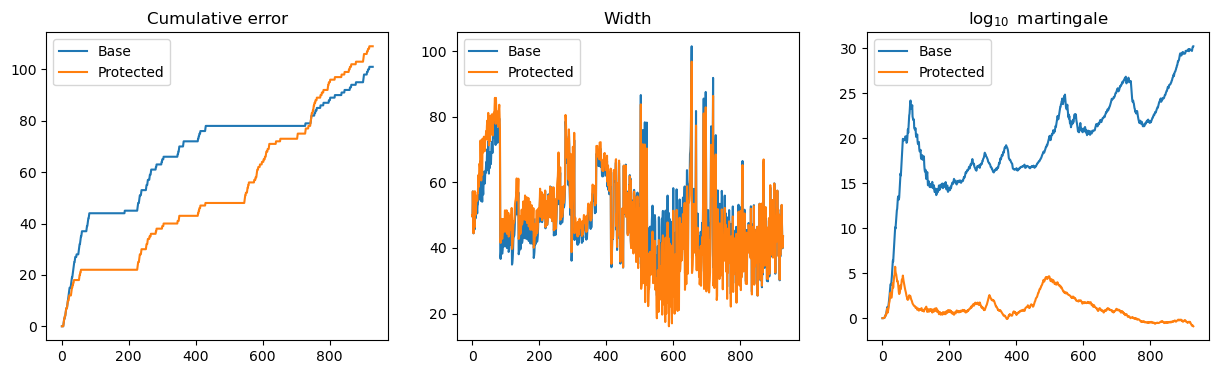

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(res[:, 0], label='Base')
axs[0].plot(res[:, 2], label='Protected')
axs[0].legend()
axs[0].set_title('Cumulative error')

axs[1].plot(res[:, 1], label='Base')
axs[1].plot(res[:, 3], label='Protected')
axs[1].legend()
axs[1].set_title('Width')

axs[2].plot(martingale.log10_martingale_values, label='Base')
axs[2].plot(calibration_martingale.log10_martingale_values, label='Protected')
axs[2].legend()
axs[2].set_title(r'$\log_{10}$ martingale')

In [18]:
Err/y_run.shape[0], Err_protected/y_run.shape[0]

(0.1086021505376344, 0.11720430107526882)

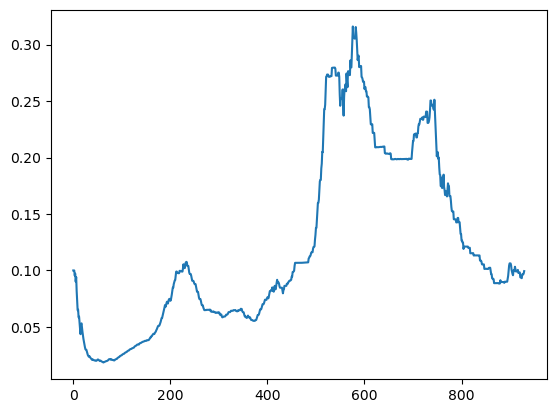

In [19]:
plt.plot(res[:,4])

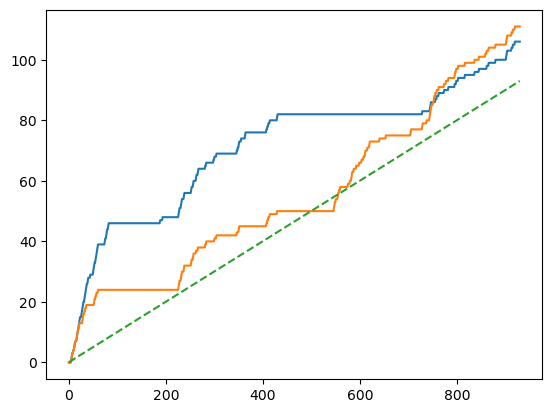

In [20]:
plt.plot((np.array(martingale.p_values) <= epsilon).cumsum(), label='Base')
plt.plot((np.array(calibration_martingale.p_values) <= epsilon).cumsum(), label='Protected')
plt.plot((np.ones_like(y_run)*epsilon).cumsum(), linestyle='--')

Going only by the smoothed p-values, it seems that the protection works well enough. However, this is not what we observe in the emprical run. Can this really be all down to the smoothing effect? The difference seems too large.

We shuold try to compute the p-value according to the formula $p^y = \frac{|\{i=1,\dots,n-1:u_i \geq y\}|+1}{n}$ as well, and compare them.

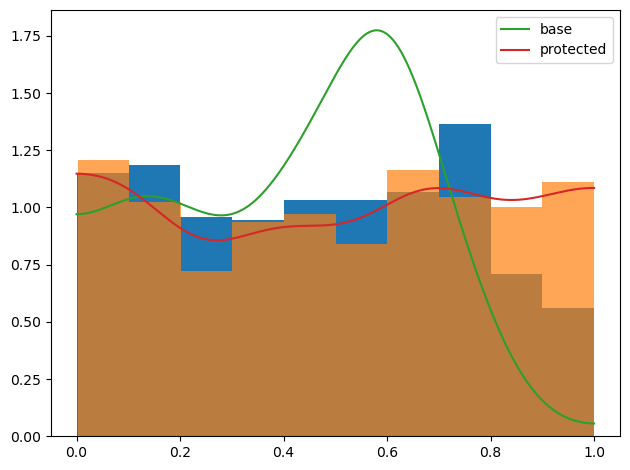

In [21]:
plt.hist(martingale.p_values, density=True)
plt.hist(calibration_martingale.p_values, density=True, alpha=0.7)
xrange = np.linspace(0, 1, endpoint=True, num=1000)
plt.plot(xrange, martingale.b_n(xrange), label='base')
plt.plot(xrange, calibration_martingale.b_n(xrange), label='protected')
plt.legend()
plt.tight_layout()
# plt.savefig('wine_original_order_hist.pdf')

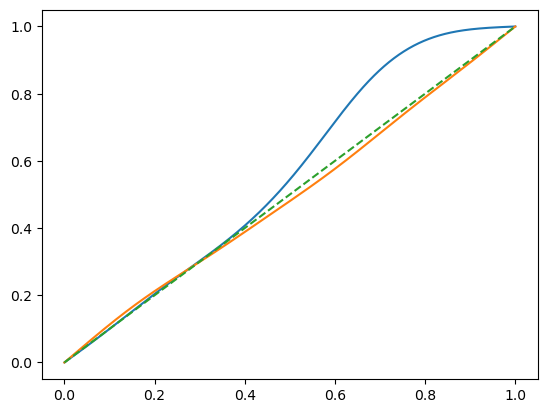

In [22]:
plt.plot(
    xrange,
    martingale.B_n(xrange)
)
plt.plot(
    xrange,
    calibration_martingale.B_n(xrange)
)
plt.plot(xrange, xrange, linestyle='--')

Text(0.5, 1.0, 'p-value as a function of y')

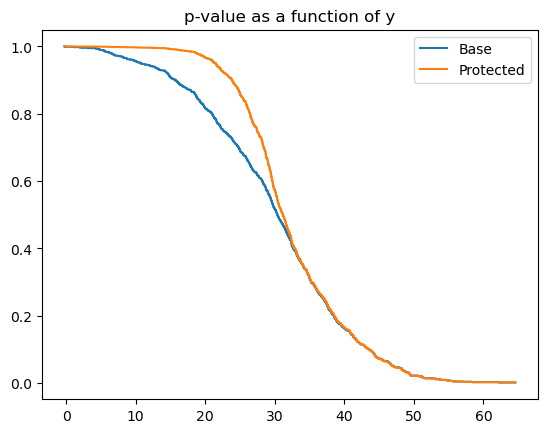

In [23]:
A, B = cp.compute_A_and_B(cp.X, cp.XTXinv, cp.y[:-1])
l_dic, u_dic = cp._vectorised_l_and_u(A, B)

def crr_p_value(y):
    U = np.array(list(u_dic.values()))
    gt = (U >= y).sum()
    return (gt + 1) / (U.shape[0] + 1)

U = np.array(list(u_dic.values()))
yrange = U

plt.step(
    yrange,
    [crr_p_value(y) for y in yrange],
    label='Base'
)
plt.step(
    yrange,
    [martingale.B_n(crr_p_value(y)) for y in yrange],
    label='Protected'
)
plt.legend()
plt.title('p-value as a function of y')

In [12]:
# Base prediction
epsilon = 0.1
n = cp.X.shape[0]
u_dic[int(np.ceil((1 - epsilon)*n))]

43.461271270275596

$$p^y = \frac{|\{i=1,\dots,n-1:u_i \geq y\}|+1}{n} > \varepsilon$$

For the protected p-value,
$$\hat{p}^y = B_n\bigg(\frac{|\{i=1,\dots,n-1:u_i \geq y\}|+1}{n}\bigg) > \varepsilon$$
kind of suggests using the quantile function, and change the inclusion rule to
$$\Gamma^{\varepsilon} = \bigg\{y\in\boldsymbol{Y}: p^y > B_n^{-1}(\varepsilon)\bigg\}.$$
However, that would require either an analytic quantile function, or solving an equation at each step...


Solving the equation...

$B_n(x) = \varepsilon$

In [13]:
from scipy.optimize import fsolve
func = lambda x: martingale.B_n(x) - epsilon
epsilon_hat = fsolve(func, epsilon)[0]

In [14]:
U[int(np.ceil((1 - epsilon)*n))-1], U[int(np.ceil((1 - epsilon_hat)*n))-1]

(43.461271270275596, 44.28436968518401)